In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils import generate_sparse, generate_sparse_randn, sign, snr, angular_error
from algos import reconstruct, reconstruct_1bit

In [12]:
# Parameters

n = 1000
s = 10

m = 1000

In [13]:
x_0 = generate_sparse_randn(n, s)
# x_0 = generate_sparse(n, s)

In [14]:
# Generate sensing matrix

A = np.random.randn(m, n)

In [15]:
# Compute y


y = sign(A.dot(x_0))

In [16]:
xx = reconstruct_1bit(y, A)

Calling solver.

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  +3.717e+00  +2e+04  1e+00  4e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +4.227e+02  +4.333e+02  +2e+04  8e-01  3e+00  8e+00  6e+00  0.5148  8e-01   1  1  1 |  0  0
 2  +3.629e+00  +2.175e+01  +5e+03  2e-01  6e-01  2e+01  2e+00  0.9890  3e-01   1  1  1 |  0  0
 3  +1.481e+00  +5.958e+00  +1e+03  4e-02  1e-01  4e+00  5e-01  0.7350  1e-02   1  1  1 |  0  0
 4  +1.413e+00  +2.391e+00  +5e+02  1e-02  3e-02  1e+00  2e-01  0.7342  7e-02   1  1  1 |  0  0
 5  +1.576e+00  +1.691e+00  +9e+01  3e-03  5e-03  1e-01  3e-02  0.8313  3e-02   1  1  1 |  0  0
 6  +2.769e+00  +2.799e+00  +3e+01  1e-03  2e-03  3e-02  1e-02  0.7545  1e-01   1  1  1 |  0  0
 7  +3.009e+00  +3.021e+00  +1e+01  6e-04  8e-04  1e-02  5e-03  0.5792  1e-01   1  1  1 |  0  0
 8  +3.131e+00  +3.134e+00  +6

In [ ]:
xx_cs = reconstruct(y, A)

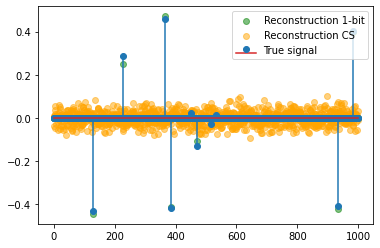

In [19]:
plt.stem(np.arange(n), x_0 / np.linalg.norm(x_0), label="True signal")
plt.scatter(np.arange(n), xx / np.linalg.norm(xx), label="Reconstruction 1-bit", alpha=0.5, color="green")
plt.scatter(np.arange(n), xx_cs / np.linalg.norm(xx_cs), label="Reconstruction CS", alpha=0.5, color="orange")
plt.legend()
plt.savefig(f"figures/recon-synth-{m}.png", dpi=800)
plt.show()

In [10]:
snr(xx / np.linalg.norm(xx), x_0 / np.linalg.norm(x_0))

15.416601546106206

In [11]:
snr(xx_cs / np.linalg.norm(xx_cs), x_0 / np.linalg.norm(x_0))

3.225577417195215

In [26]:
angular_error(xx / np.linalg.norm(xx), x_0 / np.linalg.norm(x_0))

0.08018644914027578

In [27]:
angular_error(xx_cs / np.linalg.norm(xx_cs), x_0 / np.linalg.norm(x_0))

0.1988197129653618

In [28]:
N_TRIALS = 2

In [33]:
m_n = []
avg_snr = []
avg_snr_cs = []
for m in range(1, 2 * n, 100):
    print(m/n)
    results = []
    results_cs = []
    # parallelize loop below with:
    # https://web.stanford.edu/~boyd/papers/pdf/cvxpy_paper.pdf (section 5)
    for _ in range(N_TRIALS):
        x_0 = generate_sparse_randn(n, s)
        x_0_norm = x_0 / np.linalg.norm(x_0)
        A = np.random.randn(m, n)
        y = sign(A.dot(x_0))
        xx = reconstruct_1bit(y, A)
        xx_norm = xx / np.linalg.norm(xx)
        xx_cs = reconstruct(y, A)
        xx_cs_norm = xx_cs / np.linalg.norm(xx_cs)
        results.append(snr(xx_norm, x_0_norm))
        results_cs.append(snr(xx_cs_norm, x_0_norm))
    m_n.append(m)
    avg_snr.append(np.mean(results))
    avg_snr_cs.append(np.mean(results_cs))

0.001
0.101
0.201
0.301
0.401
0.501
0.601
0.701
0.801
0.901


/home/theophile/.m2a/lib/python3.7/site-packages/cvxpy/problems/problem.py:1126: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


1.001


KeyboardInterrupt: 

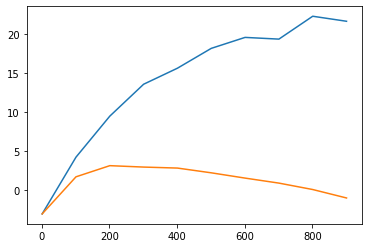

In [34]:
plt.plot(m_n, avg_snr)
plt.plot(m_n, avg_snr_cs)